In [ ]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="-1"  

In [ ]:
import pretty_midi
import midi
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Model
from keras.layers import Dense, Input, Lambda, Concatenate, LSTM

from keras.optimizers import Adam

from keras import backend as K

import copy

import tensorflow as tf
#import tensorflow_probability as tfp # for tf version 2.0.0, tfp version 0.8 is needed 
import numpy as np

import matplotlib.pyplot as plt
import csv
from sys import stdout
import random

import librosa.display
import pypianoroll


# My code
from loading import *
from models import *
from data import *
from midi_to_statematrix import *

%matplotlib inline

In [3]:
print("TensorFlow version: {}".format(tf.__version__))
print("GPU is available: {}".format(tf.test.is_gpu_available()))

TensorFlow version: 2.0.0
GPU is available: False


# Load data

In [ ]:
file = 'maestro-v2.0.0/maestro-v2.0.0.csv'

In [ ]:
# Call data class
data = DataObject(file, what_type = 'train', train_tms = 100, test_tms = 100, fs = 20, window_size = 15)

# Create a batch class which we will iterate over
train_batch = Batch(data, batch_size = 16, songs_per_batch = 4)

In [ ]:
curr_batch = train_batch.data
curr_batch.featurize(use_biaxial = True)

# Define model

In [ ]:
def my_binary_loss_seq(y_true, y_pred):
    y_true = tf.reshape(y_true, [-1, 78])
    y_pred = tf.reshape(y_pred, [-1, 78])
    
    bce = tf.keras.losses.BinaryCrossentropy()
    
    return bce(y_true, y_pred)

In [ ]:
model = biaxial_pn_encoder_concat_deeplstm(curr_batch, 32)
model.compile(loss = tf.keras.losses.BinaryCrossentropy(), optimizer = Adam(learning_rate=0.0005))


In [ ]:
model = biaxial_target_conv2d_model(curr_batch)
model.compile(loss = tf.keras.losses.BinaryCrossentropy(), optimizer = Adam(learning_rate=0.0005))

In [ ]:
curr_batch.target_train.shape

In [ ]:
model.summary()

In [ ]:
def inputize(curr_batch):
    
    train_target = curr_batch.target
    train_target = tf.roll(train_target, shift=1, axis=1)
    train_target = train_target.numpy()
    train_target[:,0,:] = curr_batch.context[:,-1,-1,:]
    
    return [curr_batch.context, train_target]

def generate(train_batch):
    """a generator for batches, so model.fit_generator can be used. """
    while True:
        new_batch    = next(train_batch)
        new_batch.featurize(use_biaxial = False)
        yield ([tf.convert_to_tensor(new_batch.context, dtype = tf.float32), 
                tf.convert_to_tensor(new_batch.target_train, dtype = tf.float32)], 
               tf.convert_to_tensor(new_batch.target_pred, dtype = tf.float32))

In [ ]:
out = model.predict([tf.convert_to_tensor(curr_batch.context, dtype = tf.float32), 
                tf.convert_to_tensor(curr_batch.target_train, dtype = tf.float32)], steps = 1)

In [ ]:
DataObject.drop_articulation(curr_batch.target_pred)

In [ ]:
out

In [ ]:
history = model.fit_generator(
                    generate(train_batch),
                    steps_per_epoch=1024,
                    epochs=5)
model.save_weights('model_biaxial_oneseq_nofeat.h5')

In [ ]:
model.save_weights('model_rolled_target.h5')

In [ ]:
history.history['loss']

In [ ]:
out = model.predict([tf.convert_to_tensor(curr_batch.context, dtype = tf.float32), 
                tf.convert_to_tensor(curr_batch.target_train, dtype = tf.float32)], steps = 1)

In [ ]:
curr_batch.target_pred[57,2,:]

In [ ]:
out[57,5,:]

In [ ]:
out[:,:,:].max()

In [ ]:
curr_batch.target_train.shape

In [ ]:
def get_decoder_simple(model):

    input_shape = model.get_layer("lambda_2").output.shape

    input_embedding = Input(batch_shape = 
                          (input_shape[0],  # batch_size
                           None,            # timesteps ()
                           input_shape[2]),  # note_size
                          name="Input_layer_embedding")

    decoder, _, _ = LSTM(units = 512, 
                      return_sequences = True,
                      return_state = True,
                      activation = 'tanh',
                      name = 'Decoder_lstm_1')(input_embedding)

    decoder = LSTM(units = 88, 
                      activation = 'sigmoid',
                      name = 'Decoder_lstm_2')(decoder)

    new_model = Model(input_embedding, decoder)
    
    names = {layer.name:idx for idx, layer in enumerate(model.layers)}
    weights = model.get_weights()

    for idx, layer in enumerate(new_model.layers):
        if layer.name in names.keys():
            new_model.layers[idx].set_weights(weights[names[layer.name]])

    return new_model

In [ ]:
#decoder = get_decoder_simple(model)
#decoder.summary()

#weights_list = model.get_weights()

In [ ]:
out = model([curr_batch.context, curr_batch.target_train])

# Create music! (inefficient version) + features 

In [ ]:
def load_model(file, curr_batch, modelname, *modelparams):
    new_model = modelname(curr_batch, *modelparams)
    
    new_model.load_weights(file)
    
    return new_model

In [ ]:
#my_model_name = "biaxial_window_feature_15_window.h5"
my_model_name = 'biaxial_pn_encoder_concat_deeplstm.h5'

In [ ]:
import pickle
pickle.dump(curr_test_batch, file = open('good_batch_for_graph_66.p', 'wb'))

In [ ]:
favorite_color = pickle.load( open( "good_batch_for_graph_66.p", "rb" ) )

In [ ]:
file = 'maestro-v2.0.0/maestro-v2.0.0.csv'
# Get a batch we want to predict
data_test = DataObject(file, what_type = 'train', train_tms = 40, test_tms = 20, fs = 20, window_size = 9)

# Create a batch class which we will iterate over
test_batch = Batch(data_test, batch_size = 64, songs_per_batch = 4)

curr_test_batch = copy.deepcopy(test_batch.data)
curr_test_batch.target_split = 0
curr_test_batch.window_size  = 1
curr_test_batch.featurize(use_biaxial = True, out_seq = False)

In [ ]:
curr_test_batch = pickle.load(open( "good_batch_for_graph_66.p", "rb" ))

In [ ]:
#model = load_model(my_model_name, curr_test_batch, biaxial_target_model, 20)
model = load_model(my_model_name, curr_test_batch, biaxial_pn_encoder_concat_deeplstm)

In [ ]:
prediction = model.predict([tf.convert_to_tensor(curr_test_batch.context, dtype = tf.float32), 
                        tf.convert_to_tensor(curr_test_batch.target_train, dtype = tf.float32)],
                          steps = 1)

In [ ]:
#my_model_name = "biaxial_window_feature_15_window.h5"
my_model_name = 'biaxial_pn_encoder_concat_deeplstm_cont.h5'

#curr_test_batch = copy.deepcopy(test_batch.data)
curr_test_batch = copy.deepcopy(favorite_color)

#curr_test_batch.target = np.zeros((64, 20, 78, 2))

curr_test_batch.target_split = 0
curr_test_batch.window_size  = data_test.test_tms
curr_test_batch.featurize(use_biaxial = True, out_seq = False)

#model = load_model(my_model_name, curr_test_batch, biaxial_target_model, 20)
model = load_model(my_model_name, curr_test_batch, biaxial_pn_encoder_concat_deeplstm)

prediction = model.predict([tf.convert_to_tensor(curr_test_batch.context, dtype = tf.float32), 
                        tf.convert_to_tensor(curr_test_batch.target_train, dtype = tf.float32)],
                          steps = 1)

In [ ]:
my_model_name = 'biaxial_pn_encoder_concat_deeplstm_cont.h5'

curr_test_batch = copy.deepcopy(test_batch.data)

seq_preds = np.zeros((64, 20, 78))
seq_preds[:,0,:] = DataObject.drop_articulation3d(curr_test_batch.target[:,0,:,:])
for win in range(1,20):
    
    print(win)
    
    curr_test_batch = copy.deepcopy(test_batch.data)
    curr_test_batch.target_split = 0
    #curr_test_batch.window_size  = data_test.test_tms
    curr_test_batch.window_size = win
    curr_test_batch.featurize(use_biaxial = True, out_seq = False)

    #model = load_model(my_model_name, curr_test_batch, biaxial_target_model, 20)
    model = load_model(my_model_name, curr_test_batch, biaxial_pn_encoder_concat_deeplstm)

    seq_preds[:,win,:] = model.predict([tf.convert_to_tensor(curr_test_batch.context, dtype = tf.float32), 
                            tf.convert_to_tensor(curr_test_batch.target_train, dtype = tf.float32)],
                              steps = 1)[:,-1,:]

In [ ]:
prediction.shape

In [4]:
def plot_pianoroll(
    ax,
    pianoroll,
    is_drum=False,
    beat_resolution=None,
    downbeats=None,
    preset="default",
    cmap="Blues",
    xtick="auto",
    ytick="octave",
    xticklabel=True,
    yticklabel="auto",
    tick_loc=None,
    tick_direction="in",
    label="both",
    grid="both",
    grid_linestyle=":",
    grid_linewidth=0.5,
    num_notes = 78,
    x_start = 1,
    alpha = 1,
):
    """
    Plot a pianoroll given as a numpy array.

    Parameters
    ----------
    ax : matplotlib.axes.Axes object
        A :class:`matplotlib.axes.Axes` object where the pianoroll will be
        plotted on.
    pianoroll : np.ndarray
        A pianoroll to be plotted. The values should be in [0, 1] when data type
        is float, and in [0, 127] when data type is integer.

        - For a 2D array, shape=(num_time_step, num_pitch).
        - For a 3D array, shape=(num_time_step, num_pitch, num_channel), where
          channels can be either RGB or RGBA.

    is_drum : bool
        A boolean number that indicates whether it is a percussion track.
        Defaults to False.
    beat_resolution : int
        The number of time steps used to represent a beat. Required and only
        effective when `xtick` is 'beat'.
    downbeats : list
        An array that indicates whether the time step contains a downbeat (i.e.,
        the first time step of a bar).

    preset : {'default', 'plain', 'frame'}
        A string that indicates the preset theme to use.

        - In 'default' preset, the ticks, grid and labels are on.
        - In 'frame' preset, the ticks and grid are both off.
        - In 'plain' preset, the x- and y-axis are both off.

    cmap :  `matplotlib.colors.Colormap`
        The colormap to use in :func:`matplotlib.pyplot.imshow`. Defaults to
        'Blues'. Only effective when `pianoroll` is 2D.
    xtick : {'auto', 'beat', 'step', 'off'}
        A string that indicates what to use as ticks along the x-axis. If 'auto'
        is given, automatically set to 'beat' if `beat_resolution` is also given
        and set to 'step', otherwise. Defaults to 'auto'.
    ytick : {'octave', 'pitch', 'off'}
        A string that indicates what to use as ticks along the y-axis.
        Defaults to 'octave'.
    xticklabel : bool
        Whether to add tick labels along the x-axis. Only effective when `xtick`
        is not 'off'.
    yticklabel : {'auto', 'name', 'number', 'off'}
        If 'name', use octave name and pitch name (key name when `is_drum` is
        True) as tick labels along the y-axis. If 'number', use pitch number. If
        'auto', set to 'name' when `ytick` is 'octave' and 'number' when `ytick`
        is 'pitch'. Defaults to 'auto'. Only effective when `ytick` is not
        'off'.
    tick_loc : tuple or list
        The locations to put the ticks. Availables elements are 'bottom', 'top',
        'left' and 'right'. Defaults to ('bottom', 'left').
    tick_direction : {'in', 'out', 'inout'}
        A string that indicates where to put the ticks. Defaults to 'in'. Only
        effective when one of `xtick` and `ytick` is on.
    label : {'x', 'y', 'both', 'off'}
        A string that indicates whether to add labels to the x-axis and y-axis.
        Defaults to 'both'.
    grid : {'x', 'y', 'both', 'off'}
        A string that indicates whether to add grids to the x-axis, y-axis, both
        or neither. Defaults to 'both'.
    grid_linestyle : str
        Will be passed to :meth:`matplotlib.axes.Axes.grid` as 'linestyle'
        argument.
    grid_linewidth : float
        Will be passed to :meth:`matplotlib.axes.Axes.grid` as 'linewidth'
        argument.

    """
    
    if pianoroll.ndim not in (2, 3):
        raise ValueError("`pianoroll` must be a 2D or 3D numpy array")
    if pianoroll.shape[1] != num_notes:
        raise ValueError("The length of the second axis of `pianoroll` must be 128.")
    if xtick not in ("auto", "beat", "step", "off"):
        raise ValueError("`xtick` must be one of {'auto', 'beat', 'step', 'none'}.")
    if xtick == "beat" and beat_resolution is None:
        raise ValueError("`beat_resolution` must be specified when `xtick` is 'beat'.")
    if ytick not in ("octave", "pitch", "off"):
        raise ValueError("`ytick` must be one of {octave', 'pitch', 'off'}.")
    if not isinstance(xticklabel, bool):
        raise TypeError("`xticklabel` must be bool.")
    if yticklabel not in ("auto", "name", "number", "off"):
        raise ValueError(
            "`yticklabel` must be one of {'auto', 'name', 'number', 'off'}."
        )
    if tick_direction not in ("in", "out", "inout"):
        raise ValueError("`tick_direction` must be one of {'in', 'out', 'inout'}.")
    if label not in ("x", "y", "both", "off"):
        raise ValueError("`label` must be one of {'x', 'y', 'both', 'off'}.")
    if grid not in ("x", "y", "both", "off"):
        raise ValueError("`grid` must be one of {'x', 'y', 'both', 'off'}.")

    # plotting
    if pianoroll.ndim > 2:
        to_plot = pianoroll.transpose(1, 0, 2)
    else:
        to_plot = pianoroll.T
    if np.issubdtype(pianoroll.dtype, np.bool_) or np.issubdtype(
        pianoroll.dtype, np.floating
    ):
        ax.imshow(
            to_plot,
            cmap=cmap,
            aspect="auto",
            vmin=0,
            vmax=1,
            origin="lower",
            interpolation="none",
            alpha = alpha,
        )
    elif np.issubdtype(pianoroll.dtype, np.integer):
        ax.imshow(
            to_plot,
            cmap=cmap,
            aspect="auto",
            vmin=0,
            vmax=127,
            origin="lower",
            interpolation="none",
            alpha = alpha,
        )
    else:
        raise TypeError("Unsupported data type for `pianoroll`.")

    # tick setting
    if tick_loc is None:
        tick_loc = ("bottom", "left")
    if xtick == "auto":
        xtick = "beat" if beat_resolution is not None else "step"
    if yticklabel == "auto":
        yticklabel = "name" if ytick == "octave" else "number"

    if preset == "plain":
        ax.axis("off")
    elif preset == "frame":
        ax.tick_params(
            direction=tick_direction,
            bottom=False,
            top=False,
            left=False,
            right=False,
            labelbottom=False,
            labeltop=False,
            labelleft=False,
            labelright=False,
        )
    else:
        ax.tick_params(
            direction=tick_direction,
            bottom=("bottom" in tick_loc),
            top=("top" in tick_loc),
            left=("left" in tick_loc),
            right=("right" in tick_loc),
            labelbottom=(xticklabel != "off"),
            labelleft=(yticklabel != "off"),
            labeltop=False,
            labelright=False,
        )

    # x-axis
    if xtick == "beat" and preset != "frame":
        num_beat = pianoroll.shape[0] // beat_resolution
        ax.set_xticks(beat_resolution * np.arange(num_beat) - 0.5)
        ax.set_xticklabels("")
        ax.set_xticks(beat_resolution * (np.arange(num_beat) + 0.5) - 0.5, minor=True)
        ax.set_xticklabels(np.arange(x_start, num_beat + 1), minor=True)
        ax.tick_params(axis="x", which="minor", width=0)

    # y-axis
    if ytick == "octave":
        ax.set_yticks(np.arange(0, num_notes, 12))
        if yticklabel == "name":
            ax.set_yticklabels(["C{}".format(i - 2) for i in range(11)])
    elif ytick == "step":
        ax.set_yticks(np.arange(0, num_notes))
        if yticklabel == "name":
            if is_drum:
                ax.set_yticklabels(
                    [pretty_midi.note_number_to_drum_name(i) for i in range(num_notes)]
                )
            else:
                ax.set_yticklabels(
                    [pretty_midi.note_number_to_name(i) for i in range(num_notes)]
                )

    # axis labels
    if label in ("x", "both"):
        if xtick == "step" or not xticklabel:
            ax.set_xlabel("time (step)")
        else:
            ax.set_xlabel("time (beat)")

    if label in ("y", "both"):
        if is_drum:
            ax.set_ylabel("key name")
        else:
            ax.set_ylabel("pitch")

    # grid
    if grid != "off":
        ax.grid(
            axis=grid, color="k", linestyle=grid_linestyle, linewidth=grid_linewidth
        )

    # downbeat boarder
    if downbeats is not None and preset != "plain":
        for step in downbeats:
            ax.axvline(x=step, color="k", linewidth=1)
            

In [ ]:
old_prediction = copy.deepcopy(prediction)

In [ ]:
prediction = copy.deepcopy(old_prediction)

In [ ]:
prediction[33,19,:]

In [ ]:
max_indices = np.zeros(prediction.shape)
for batch in range(prediction.shape[0]):
    for timestep in range(prediction.shape[1]):
        
        max_indices[batch,timestep,prediction[batch,timestep,:].argmax()] = 1 
        prediction[batch,timestep,:] /= np.sum(prediction[batch,timestep,:])
        
        
        #turn_off = prediction[batch,timestep,:].argsort()[:-20]
        #prediction[batch,timestep,turn_off] = 0
        pass

In [5]:
def pad_with_zeros(pianoroll):
    return np.pad(pianoroll, ((0,0),(25, 25)), 'constant', constant_values=(0, 0))

def combine_pianoroll(*pianorolls):
    
    for idx, pianoroll in enumerate(pianorolls):
        if idx == 0:
            new_pianoroll = pianoroll
        else:
            new_pianoroll = np.append(new_pianoroll, pianoroll, axis = 0)
    
    return new_pianoroll

def plot_batch_element(batch, which_element = 0, cmap_ctx = 'viridis', cmap_tar = 'Reds', num_subplots = 3, figsize = (12,8)):
    fig = plt.figure(figsize = figsize)
    ax = fig.add_subplot(num_subplots*100 + 11)
    
    full_segment = combine_pianoroll(batch.context[which_element,0,:,:],
                                     np.zeros(DataObject.drop_articulation3d(batch.target[which_element,:,:]).shape),
                                     batch.context[which_element,1,:,:])
    
    just_target = np.zeros(full_segment.shape)
    just_target[40:60, :] = DataObject.drop_articulation3d(batch.target[which_element,:,:])
    
    plot_pianoroll(ax, full_segment, cmap = cmap_ctx)
    plot_pianoroll(ax, just_target,  cmap = cmap_tar, alpha = 1)
    ax.axvline(data_test.train_tms)
    ax.axvline(data_test.train_tms+data_test.test_tms)
    
    return fig, ax


In [ ]:
weighted_average = np.zeros((prediction.shape[0], prediction.shape[1]))
for timestep in range(0, prediction.shape[1]):
    for batch in range(0, prediction.shape[0]):
        weighted_average[batch, timestep] = np.round(np.average(np.arange(0,78,1), weights = prediction[batch, timestep, :]))

In [ ]:
weighted_sd = np.zeros((prediction.shape[0], prediction.shape[1]))
for timestep in range(0, prediction.shape[1]):
    for batch in range(0, prediction.shape[0]):
        weighted_sd[batch, timestep] = np.round(np.average((np.arange(0,78,1) - weighted_average[batch, timestep])**2, weights = prediction[batch, timestep, :]))

In [6]:
from matplotlib.colors import ListedColormap

# Choose colormap
cmap = plt.cm.Wistia

# Get the colormap colors
my_cmap = cmap(np.arange(cmap.N))

# Set alpha
my_cmap[:,-1] = np.linspace(0, 1, cmap.N)

# Create new colormap
my_cmap = ListedColormap(my_cmap)

In [ ]:
which_indices = np.zeros((64, 20))
for batch in range(64):
    for timestep in range(20):
        which_indices[batch, timestep] = np.where(max_indices[batch, timestep, :] == 1)[0][0]

In [ ]:
batchnum1 = 33
batchnum2 = 33
cmap = 'Blues'
meancol = 'red'

fig, ax = plot_batch_element(curr_test_batch, batchnum1, cmap_ctx = cmap, cmap_tar = my_cmap, num_subplots = 1,
                            figsize = (12,6))

ax.set_xticks(np.arange(0,2*data_test.train_tms + data_test.test_tms,data_test.test_tms/2))
ax.set_xticklabels(np.arange(0,2*data_test.train_tms + data_test.test_tms,data_test.test_tms/2))

ax.set_xlabel('Timestep')
ax.set_ylabel('Pitch')

fig.savefig('graphs/top_graph.png', dpi = 300, bbox_inches = 'tight')

In [ ]:
batchnum1 = 33
batchnum2 = 33
cmap = 'Blues'
meancol = 'red'

fig = plt.figure(figsize = (12,12))

ax2 = fig.add_subplot(212)
ax3 = fig.add_subplot(211)


plot_pianoroll(ax3, 
                           128*DataObject.drop_articulation3d(curr_test_batch.target[batchnum2,:,:,:]),
                           cmap=my_cmap, alpha = 1)   ######### TRUE
#plot_pianoroll(ax3, 
#                           0.05*128*seq_preds[batchnum1,:,:],
#                            cmap=cmap, alpha = 0.5) ######### SEQ_PREDS
plot_pianoroll(ax2, 
                           0.1*128*prediction[batchnum2,:,:],
                           cmap=cmap)               ######### PREDICTION

ax2.plot(weighted_average[batchnum2,:], ':',
         linewidth = 3, color = meancol, alpha = 0.6)          ######### AVERAGE PREDICTION
ax2.fill_between(np.arange(0, 20, 1), 
                 weighted_average[batchnum2,:]-np.sqrt(weighted_sd)[batchnum2,:], 
                 weighted_average[batchnum2,:]+np.sqrt(weighted_sd)[batchnum2,:],
                 alpha = 0.1, color = meancol)

ax3.plot(weighted_average[batchnum2,:], ':',
         linewidth = 3, color = meancol, alpha = 0.8, label = 'Mean predicted key')######### AVERAGE PREDICTION
ax3.fill_between(np.arange(0, 20, 1), 
                 weighted_average[batchnum2,:]-np.sqrt(weighted_sd)[batchnum2,:], 
                 weighted_average[batchnum2,:]+np.sqrt(weighted_sd)[batchnum2,:],
                 alpha = 0.15, color = meancol)

#ax3.plot(which_indices[batchnum2,:], color = 'purple')

ax2.set_xticks(np.arange(0,data_test.test_tms,1))
ax2.set_xticklabels(np.arange(data_test.train_tms+1,data_test.train_tms+data_test.test_tms+1,1))

ax3.set_xticks(np.arange(0,data_test.test_tms,1))
ax3.set_xticklabels(np.arange(data_test.train_tms+1,data_test.train_tms+data_test.test_tms+1,1))

ax3.set_xlabel('')

ax3.set_title('True target overlayed with mean predicted key', fontsize = 18)
ax3.legend()

ax2.set_title('Predicted probability of playing key', fontsize = 18)
ax2.set_xlabel('Timestep')
ax2.set_ylabel('Pitch')
ax3.set_ylabel('Pitch')

fig.savefig('graphs/mid_bott_graph.png', dpi = 300, bbox_inches = 'tight')


In [ ]:
import matplotlib.pyplot as plt
import matplotlib as mpl

fig, ax = plt.subplots(figsize=(1, 20))
fig.subplots_adjust(bottom=0.5)

cmap = mpl.cm.Blues
norm = mpl.colors.Normalize(vmin=0, vmax=0.6)

cb1 = mpl.colorbar.ColorbarBase(ax, cmap=cmap,
                                norm=norm,
                                orientation='vertical')
#cb1.set_label('Probability of playing key', fontsize=25)

font_size = 25 # Adjust as appropriate.
cb1.ax.tick_params(labelsize=font_size)

fig.show()

fig.savefig('graphs/colorbar_graph.png', dpi = 300, bbox_inches = 'tight')

In [ ]:
batchnum1 = 33
batchnum2 = 33
cmap = 'Blues'
meancol = 'red'

fig, ax = plot_batch_element(curr_test_batch, batchnum1, cmap_ctx = cmap, cmap_tar = my_cmap, num_subplots = 3, 
                            figsize = (12,12))

#fig2 = plt.figure(figsize = (12,8))
#fig3 = plt.figure(figsize = (12,8))


ax2 = fig.add_subplot(313)
ax3 = fig.add_subplot(312)
#plot_pianoroll(ax2, 
#                           0.5*128*np.multiply(prediction[batchnum,:,:],1/np.tile(np.expand_dims(np.sum(prediction[batchnum,:,:], -1), -1), [1,78])),
#                           cmap='Reds')

plot_pianoroll(ax3, 
                           128*DataObject.drop_articulation3d(curr_test_batch.target[batchnum2,:,:,:]),
                           cmap=my_cmap, alpha = 1)   ######### TRUE
#plot_pianoroll(ax3, 
#                           0.05*128*seq_preds[batchnum1,:,:],
#                            cmap=cmap, alpha = 0.5) ######### SEQ_PREDS
plot_pianoroll(ax2, 
                           0.1*128*prediction[batchnum2,:,:],
                           cmap=cmap)               ######### PREDICTION

ax2.plot(weighted_average[batchnum2,:], ':',
         linewidth = 3, color = meancol, alpha = 0.6)          ######### AVERAGE PREDICTION
ax2.fill_between(np.arange(0, 20, 1), 
                 weighted_average[batchnum2,:]-np.sqrt(weighted_sd)[batchnum2,:], 
                 weighted_average[batchnum2,:]+np.sqrt(weighted_sd)[batchnum2,:],
                 alpha = 0.1, color = meancol)

ax3.plot(weighted_average[batchnum2,:], ':',
         linewidth = 3, color = meancol, alpha = 0.8, label = 'Mean predicted key')######### AVERAGE PREDICTION
ax3.fill_between(np.arange(0, 20, 1), 
                 weighted_average[batchnum2,:]-np.sqrt(weighted_sd)[batchnum2,:], 
                 weighted_average[batchnum2,:]+np.sqrt(weighted_sd)[batchnum2,:],
                 alpha = 0.15, color = meancol)

#ax3.plot(which_indices[batchnum2,:], color = 'purple')

ax2.set_xticks(np.arange(0,data_test.test_tms,1))
ax2.set_xticklabels(np.arange(data_test.train_tms+1,data_test.train_tms+data_test.test_tms+1,1))

ax.set_xticks(np.arange(0,2*data_test.train_tms + data_test.test_tms,data_test.test_tms/2))
ax.set_xticklabels(np.arange(0,2*data_test.train_tms + data_test.test_tms,data_test.test_tms/2))

ax3.set_xticks(np.arange(0,data_test.test_tms,1))
ax3.set_xticklabels(np.arange(data_test.train_tms+1,data_test.train_tms+data_test.test_tms+1,1))

ax3.set_xlabel('')
ax.set_xlabel('')


### Now we compare if we switch the order of left and right

In [61]:
curr_test_batch_normal = pickle.load(open( "good_batch_for_graph_66.p", "rb" ))
curr_test_batch_normal.target = np.zeros(curr_test_batch_normal.target.shape)


curr_test_batch_switch = pickle.load(open( "good_batch_for_graph_66.p", "rb" ))
curr_test_batch_switch.context[:,[0,1],:,:] = curr_test_batch_switch.context[:,[1,0],:,:]
curr_test_batch_switch.target = np.zeros(curr_test_batch_switch.target.shape)



prediction_normal = model.predict([tf.convert_to_tensor(curr_test_batch_normal.context, dtype = tf.float32), 
                        tf.convert_to_tensor(curr_test_batch_normal.target_train, dtype = tf.float32)],
                          steps = 1)

prediction_switch = model.predict([tf.convert_to_tensor(curr_test_batch_switch.context, dtype = tf.float32), 
                        tf.convert_to_tensor(curr_test_batch_switch.target_train, dtype = tf.float32)],
                          steps = 1)


In [78]:
file = 'maestro-v2.0.0/maestro-v2.0.0.csv'
# Get a batch we want to predict
data_test = DataObject(file, what_type = what_type, 
                       train_tms = train_tms, test_tms = test_tms, 
                       fs = 20, window_size = 15,
                       seed = seed)

# Create a batch class which we will iterate over
test_batch = Batch(data_test, batch_size = batch_size, songs_per_batch = songs_per_batch)


############################################# START GENERATING #############################################

#test_batch.data = pickle.load(open( "good_batch_for_graph_66.p", "rb" ))
#test_batch.data.context = np.transpose(test_batch.data.context, [1,0,2,3])

curr_test_batch = copy.deepcopy(test_batch.data)
curr_test_batch.target_split = 0
curr_test_batch.window_size  = 20
curr_test_batch.featurize(use_biaxial = True)

In [ ]:
batchnum = 40
cmap = 'Blues'
meancol = 'red'


fig, ax = plot_batch_element(curr_test_batch, batchnum, cmap_ctx = cmap, cmap_tar = my_cmap, num_subplots = 3, 
                            figsize = (12,12))

#fig2 = plt.figure(figsize = (12,8))
#fig3 = plt.figure(figsize = (12,8))


ax2 = fig.add_subplot(312)
ax3 = fig.add_subplot(313)
#plot_pianoroll(ax2, 
#                           0.5*128*np.multiply(prediction[batchnum,:,:],1/np.tile(np.expand_dims(np.sum(prediction[batchnum,:,:], -1), -1), [1,78])),
#                           cmap='Reds')

plot_pianoroll(ax2,0.1*128*prediction_normal[batchnum,:,:],cmap=cmap) # NORMAL  

plot_pianoroll(ax3,0.1*128*prediction_switch[batchnum,:,:],cmap=cmap) # NORMAL  



In [79]:
def plot_batch_element2(batch, fig, which_element = 0, cmap_ctx = 'viridis', cmap_tar = 'Reds', num_subplot = 2):
    ax = fig.add_subplot(300 + 10 + num_subplot)
    
    full_segment = combine_pianoroll(batch.context[which_element,0,:,:],
                                     np.zeros(batch.target[which_element,:,:].shape),
                                     batch.context[which_element,1,:,:])
    
    just_target = np.zeros(full_segment.shape)
    just_target[40:60, :] = batch.target[which_element,:,:]
    
    plot_pianoroll(ax, full_segment, cmap = cmap_ctx)
    plot_pianoroll(ax, just_target,  cmap = cmap_tar, alpha = 1)
    ax.axvline(data_test.train_tms)
    ax.axvline(data_test.train_tms+data_test.test_tms)
    
    return fig, ax

# Choose colormap
cmap2 = plt.cm.Reds

# Get the colormap colors
my_cmap2 = cmap2(np.arange(cmap2.N))

# Set alpha
my_cmap2[:,-1] = np.linspace(0, 1, cmap2.N)

# Create new colormap
my_cmap2 = ListedColormap(my_cmap2)




Text(0.5, 0, '')

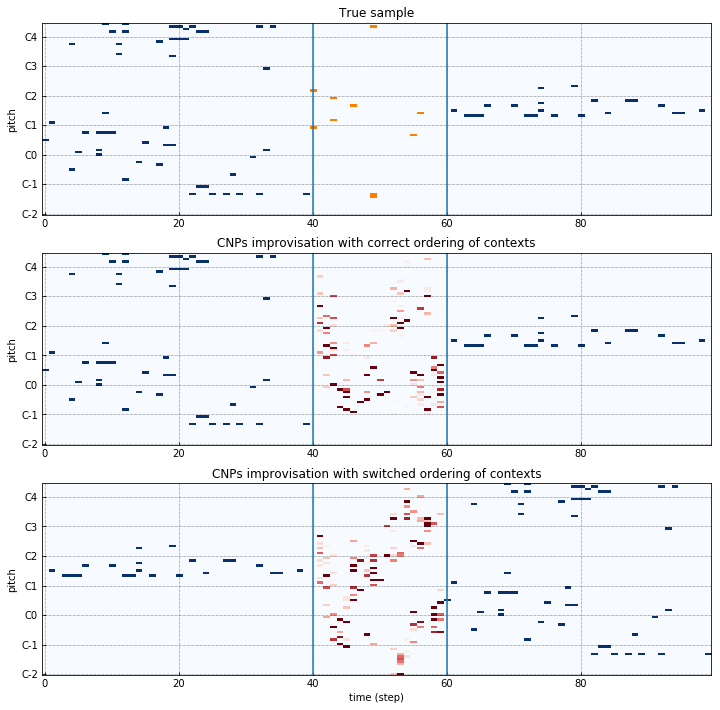

In [128]:
batchnum = 17
cmap = 'Blues'
meancol = 'red'

fig, ax = plot_batch_element(curr_test_batch, batchnum, cmap_ctx = cmap, cmap_tar = my_cmap, num_subplots = 3, 
                            figsize = (12,12))

#fig2 = plt.figure(figsize = (12,8))
#fig3 = plt.figure(figsize = (12,8))


#ax2 = fig.add_subplot(312)
#ax3 = fig.add_subplot(313)
#plot_pianoroll(ax2, 
#                           0.5*128*np.multiply(prediction[batchnum,:,:],1/np.tile(np.expand_dims(np.sum(prediction[batchnum,:,:], -1), -1), [1,78])),
#                           cmap='Reds')

temp_test_batch = copy.deepcopy(curr_test_batch)
temp_test_batch.target = prediction_normal*4

fig, ax2 = plot_batch_element2(temp_test_batch, fig, batchnum, cmap_ctx = cmap, cmap_tar = my_cmap2, num_subplot = 2)

temp_test_batch = copy.deepcopy(curr_test_batch)
temp_test_batch.target = prediction_switch*4
temp_test_batch.context[:,[0,1],:,:] = temp_test_batch.context[:,[1,0],:,:]



fig, ax3 = plot_batch_element2(temp_test_batch, fig, batchnum, cmap_ctx = cmap, cmap_tar = my_cmap2, num_subplot = 3)

ax.set_title('True sample')
ax2.set_title('CNPs improvisation with correct ordering of contexts')
ax3.set_title('CNPs improvisation with switched ordering of contexts')

ax.set_xlabel('')
ax2.set_xlabel('')

#plot_pianoroll(ax2,0.1*128*prediction_normal[batchnum,:,:],cmap=cmap) # NORMAL  

#plot_pianoroll(ax3,0.1*128*prediction_switch[batchnum,:,:],cmap=cmap) # NORMAL  

#fig.savefig('graphs/switched_contexts_5.png', dpi = 300, bbox_inches = 'tight')


In [ ]:
import scipy.stats as st

def turn_probabilities_to_notes(prediction, how = 'random', normalize = True, threshold = 0.1, turn_on = 6):
    
    for batch in range(prediction.shape[0]):
        turn_off = prediction[batch,:].argsort()[:-turn_on]
        prediction[batch, :][turn_off] = 0
        
        if normalize:
            prediction[batch, :] = st.norm.cdf((prediction[batch, :] - 
                                                np.mean(prediction[batch, :][prediction[batch, :] > 0]))/
                                               np.sqrt(np.var(prediction[batch, :][prediction[batch, :]>0])))/4
            prediction[batch, :][turn_off] = 0
        #prediction[batch,:] = prediction[batch,:]*(0.5/np.mean(prediction[batch,:][prediction[batch,:]>0]))
        #prediction[batch,:] = prediction[batch,:]/prediction[batch,:].max()
    
    if how == 'random':
        
        notes =  np.random.binomial(1, p=prediction)
        
    elif how == 'random_thresholded':
        
        prediction[prediction >= threshold] += 0.5
        prediction[prediction > 1] = 1
        prediction[prediction < threshold] = 0
        
        notes =  np.random.binomial(1, p=prediction)
        
    elif how == 'thresholded':
        
        prediction[prediction >= threshold] = 1
        prediction[prediction < threshold] = 0
        
        notes = prediction
    
    return notes        

# ALL IN ONE EXPERIMENTAL

In [74]:
##################### GENERATION PARAMETERS #####################

my_model_name = "biaxial_pn_encoder_concat_deeplstm_cont.h5"
foldername = 'experiment_switch_order3'

# data 
what_type = 'test'
train_tms = 40
test_tms = 20
batch_size = 64
songs_per_batch = 16
seed = 1212


# turn probabilities to notes params
how = 'random'
normalize = False
remap_to_max = True
turn_on_notes = 8
divide_prob = 2
articulation_prob = 0.0018
remap_prob = 0.35

# Recurrence params
pick_pred_from_idx = 0

In [75]:
import scipy.stats as st
import os
from os import path
import sys
import pickle


def load_model(file, curr_batch, modelname, *modelparams):
    new_model = modelname(curr_batch, *modelparams)
    
    new_model.load_weights(file)
    
    return new_model

def turn_probabilities_to_notes(prediction, 
                                turn_on, 
                                how = 'random', 
                                normalize = True, 
                                threshold = 0.1, 
                                divide_prob = 2,
                                remap_to_max = True):
    
    for batch in range(prediction.shape[0]):
        if turn_on[batch] <= 1:
            prediction[batch, :] = 0
            continue
        turn_off = prediction[batch, :].argsort()[:-int(turn_on[batch])]
        prediction[batch, :][turn_off] = 0
        
        if normalize: 
            prediction[batch, timestep, :] = st.norm.cdf((prediction[batch, timestep, :] - 
                                                np.mean(prediction[batch, timestep, :][prediction[batch, timestep, :] > 0]))/
                                               np.sqrt(np.var(prediction[batch, timestep, :][prediction[batch, timestep, :]>0])))/divide_prob
            prediction[batch, timestep, :][turn_off] = 0
        
        if remap_to_max:
            prediction[batch, :] /= prediction[batch, :].max()
            prediction[batch, :] *= remap_prob
        
    if how == 'random':
        
        notes =  np.random.binomial(1, p=prediction)
        
    elif how == 'random_thresholded':
        
        prediction[prediction >= threshold] += 0.5
        prediction[prediction > 1] = 1
        prediction[prediction < threshold] = 0
        
        notes =  np.random.binomial(1, p=prediction)
        
    elif how == 'thresholded':
        
        prediction[prediction >= threshold] = 1
        prediction[prediction < threshold] = 0
        
        notes = prediction
    
    return notes     

############################################# LOAD DATA ####################################################

file = 'maestro-v2.0.0/maestro-v2.0.0.csv'
# Get a batch we want to predict
data_test = DataObject(file, what_type = what_type, 
                       train_tms = train_tms, test_tms = test_tms, 
                       fs = 20, window_size = 15,
                       seed = seed)

# Create a batch class which we will iterate over
test_batch = Batch(data_test, batch_size = batch_size, songs_per_batch = songs_per_batch)


############################################# START GENERATING #############################################

#test_batch.data = pickle.load(open( "good_batch_for_graph_66.p", "rb" ))
#test_batch.data.context = np.transpose(test_batch.data.context, [1,0,2,3])

curr_test_batch = copy.deepcopy(test_batch.data)

curr_test_batch.context[[0,1],:,:,:] = curr_test_batch.context[[1,0],:,:,:]


#curr_test_batch.target_split = 0
#curr_test_batch.window_size  = 15
#curr_test_batch.featurize(use_biaxial = True)

#model = load_model(my_model_name, curr_test_batch, biaxial_pn_encoder_concat_deeplstm)

final_output = np.zeros((test_batch.batch_size, 
                         19+data_test.test_tms+19, 
                         78))

# Populate from the front
final_output[:,0:19,:] = curr_test_batch.context[0,:,-19:,:]
final_output[:,20,:] = DataObject.drop_articulation3d(curr_test_batch.target[:,0,:,:])

# Populate from the back 
final_output[:,-19:,:] = curr_test_batch.context[1,:,0:19,:]

#all_predictions = np.zeros((test_batch.batch_size, data_test.test_tms, 78))

#new_target = np.concatenate([curr_test_batch.context[:,0,-20:0,:], 
#                      DataObject.drop_articulation(curr_test_batch.target),
#                      curr_test_batch.context[:,1,0:20,:]],
#                      axis = 1)

curr_test_batch.target[:,0:20,:,0] = final_output[:,0:20,:]
curr_test_batch.target[:,0:20,:,1] = np.zeros(final_output[:,0:20,:].shape)



curr_test_batch.target_split = 0
curr_test_batch.window_size  = 20
curr_test_batch.featurize(use_biaxial = True)

model = load_model(my_model_name, curr_test_batch, biaxial_pn_encoder_concat_deeplstm)


def take_prediction(t):
    if t<20:
        return -t
    else:
        return -20

def take_actual(t):
    if t <= test_tms:
        return np.arange(19, 19+t, 1)
    else:
        return np.arange(t-test_tms+19, t-19, 1)


for timestep in range(1,test_tms):
    
    
    stdout.write('\rtimestep {}/{}'.format(timestep, test_tms))
    stdout.flush()
    
    prediction = model.predict([tf.convert_to_tensor(curr_test_batch.context, dtype = tf.float32), 
                                tf.convert_to_tensor(curr_test_batch.target_train, dtype = tf.float32)],
                               steps = 1)[:,take_prediction(timestep):,:]
    
    notes = np.zeros(prediction.shape)
    
    turn_on = [turn_on_notes]*batch_size
    for t in range(notes.shape[1]):
        articulation = np.multiply(prediction[:,t,:], final_output[:,20+t,:])
        articulation[articulation >= articulation_prob] = 1
        articulation[articulation < articulation_prob] = 0
        articulated_notes = np.sum(articulation, axis = -1)
        
        play_notes = turn_probabilities_to_notes(prediction[:,t,:], 
                                        turn_on = turn_on - articulated_notes,
                                        how = 'random', 
                                        normalize = normalize,
                                        divide_prob = divide_prob, 
                                        remap_to_max = remap_to_max)
        
        play_notes = play_notes + articulation
        play_notes[play_notes >= 1] = 1
        play_notes[play_notes < 1] = 0
        
        final_output[:,21+t,:] = play_notes
    
    #if timestep == test_tms:
    #    sys.exit()
    #articulation = np.multiply(prediction, final_output[:,take_actual(timestep),:])
    #articulation[articulation >= articulation_prob] = 1
    #articulation[articulation < articulation_prob] = 0
    #articulated_notes = np.sum(articulation, axis = -1)
    
    #turn_on = turn_on_notes*np.ones((batch_size, timestep))
    #prediction[np.where(articulation > 0)] = 0
    
    #all_predictions[:,timestep,:] = copy.deepcopy(prediction)
    
    #notes = turn_probabilities_to_notes(prediction, 
    #                                    turn_on = turn_on - articulated_notes,
    #                                    how = 'random', 
    #                                    normalize = normalize,
    #                                    divide_prob = divide_prob)
    #notes = notes + articulation
    #notes[notes >= 1] = 1
    #notes[notes < 1] = 0
    
    #final_output[:,21:(21+timestep),:] = notes
    
    
    # Now reinitialize the model and everything
    curr_test_batch = copy.deepcopy(test_batch.data)
    
    curr_test_batch.target[:,0:20,:,0] = final_output[:,timestep:(20+timestep)]


    curr_test_batch.target_split = 0
    curr_test_batch.window_size  = 20
    curr_test_batch.featurize(use_biaxial = True)



    #model = load_model(my_model_name, curr_test_batch, biaxial_pn_encoder_concat_deeplstm)

    
    #if curr_test_batch.target.shape[1] <= 15:
    #    curr_test_batch.target_split = 0
    #    curr_test_batch.window_size  = timestep + 1
    #else:
    #    curr_test_batch.target_split = curr_test_batch.target.shape[1] - 15
    #    curr_test_batch.window_size  = curr_test_batch.target.shape[1]
    
    
    ######### WHY DO THIS?????? ######################################################

    #model = load_model(my_model_name, curr_test_batch, biaxial_target_model_oneseq, 20)
    
#np.save('{}/all_predictions.npy'.format(foldername), all_predictions)

####################################################

#sys.exit('what?')

true_batch = copy.deepcopy(test_batch.data)

song_names = np.zeros(len(true_batch.link))
song_names = song_names.tolist()
i = 0
for i, link in enumerate(true_batch.link):
    with open(data_test.file) as csv_file:
            csv_reader = csv.reader(csv_file, delimiter=',')
            line_count = 0

            for row in csv_reader:
                if line_count == 0:
                    line_count += 1
                else:
                    if row[4] == link:
                        name = str(row[0]) + '_' + str(row[1]) + '___' + str(i)
                        name = name.replace(" ", "-")
                        name = name.replace("/", "")
                        song_names[i] = name
                        break  
##########################################################                      

if path.isdir(foldername):
    os.system('rm -r {}'.format(foldername))

if not path.isdir(foldername):
    os.mkdir(foldername)

with open('{}/setup.txt'.format(foldername), 'w+') as f:
    f.write('what_type = {} \n \
             train_tms = {} \n \
             test_tms  = {} \n \
             batch_size = {} \n \
             songs_per_batch ={} \n \
             how = {} \n \
             normalize = {} \n \
             turn_on = {} \n \
             divide_prob = {} \n \
             articulation_prob = {}'.format(what_type,
                                            str(train_tms),
                                            str(test_tms),
                                            str(batch_size),
                                            str(songs_per_batch),
                                            how,
                                            str(normalize),
                                            str(turn_on[0]),
                                            str(divide_prob),
                                            str(articulation_prob)))

##########################################################

true_batch = copy.deepcopy(test_batch.data)

true_batch.target = DataObject.drop_articulation(true_batch.target)

# Combine context
true_sample = np.append(np.squeeze(curr_test_batch.context[:,0,:,:]), true_batch.target, axis = 1)
true_sample = np.append(true_sample, np.squeeze(curr_test_batch.context[:,1,:,:]), axis = 1)

true_sample = np.append(np.expand_dims(true_sample, axis = 3), 
                                  np.expand_dims(true_sample, axis = 3), axis = 3)

predicted_sample = np.append(np.squeeze(curr_test_batch.context[:,0,:,:]), final_output[:,20:(20+test_tms),:], axis = 1)
predicted_sample = np.append(predicted_sample, np.squeeze(curr_test_batch.context[:,1,:,:]), axis = 1)

predicted_sample = np.append(np.expand_dims(predicted_sample, axis = 3), 
                                       np.expand_dims(predicted_sample, axis = 3), axis = 3)

# Save final midi

#save_indices = np.random.randint(low = 0, high = test_batch.batch_size, size = 20)
save_indices = np.arange(0,test_batch.batch_size)
for idx, i in enumerate(save_indices):
    print("saving {}".format(idx))
    #noteStateMatrixToMidi(true_sample[i,:,:], name = 'best_model_full_generation/NO_{}_TRUE_{}'.format(i,song_names[i]))
    #noteStateMatrixToMidi(predicted_sample[i,:,:], name = 'best_model_full_generation/NO_{}_PRED_{}'.format(i,song_names[i]))
    
    noteStateMatrixToMidi(true_sample[i,:,:], name = '{}/NO_{}_TRUE_{}'.format(foldername,i,song_names[i]))
    noteStateMatrixToMidi(predicted_sample[i,:,:], name = '{}/NO_{}_PRED_{}'.format(foldername,i,song_names[i]))



                        

timestep 19/20saving 0
saving 1
saving 2
saving 3
saving 4
saving 5
saving 6
saving 7
saving 8
saving 9
saving 10
saving 11
saving 12
saving 13
saving 14
saving 15
saving 16
saving 17
saving 18
saving 19
saving 20
saving 21
saving 22
saving 23
saving 24
saving 25
saving 26
saving 27
saving 28
saving 29
saving 30
saving 31
saving 32
saving 33
saving 34
saving 35
saving 36
saving 37
saving 38
saving 39
saving 40
saving 41
saving 42
saving 43
saving 44
saving 45
saving 46
saving 47
saving 48
saving 49
saving 50
saving 51
saving 52
saving 53
saving 54
saving 55
saving 56
saving 57
saving 58
saving 59
saving 60
saving 61
saving 62
saving 63


In [76]:
#prediction_switch = final_output[:,20:(20+test_tms),:]
prediction_switch = np.concatenate([np.zeros((64,1,78)), prediction], axis = 1)

### Now play music in a loop looking back at everything

In [ ]:
####### GOOD INIT START #######

curr_test_batch = copy.deepcopy(test_batch.data)

first_timestep = DataObject.drop_articulation(curr_test_batch.target[:,0:15,:])

curr_test_batch.target_split = 0
curr_test_batch.window_size  = 15
curr_test_batch.featurize(use_biaxial = True)

model = load_model(my_model_name, curr_test_batch, biaxial_target_model_oneseq, 20)

final_output = np.zeros((test_batch.batch_size, data_test.test_tms, curr_test_batch.target_train.shape[-2]))
final_output[:,0:15,:] = first_timestep

all_predictions = np.zeros((test_batch.batch_size, data_test.test_tms, curr_test_batch.target_train.shape[-2]))

for timestep in range(15,100):
    
    stdout.write('\rtimestep {}/100'.format(timestep))
    stdout.flush()
    
    prediction = model.predict([tf.convert_to_tensor(curr_test_batch.context, dtype = tf.float32), 
                                tf.convert_to_tensor(curr_test_batch.target_train, dtype = tf.float32)],
                               steps = 1)
    
    all_predictions[:,timestep,:] = copy.deepcopy(prediction)
    
    notes = turn_probabilities_to_notes(prediction, how = 'random', turn_on = 8, normalize = True)
    #notes = turn_probabilities_to_notes(prediction, how = 'random', threshold = 0.2, turn_on=20, normalize = False)
    final_output[:,timestep,:] = notes
    
    
    # Now reinitialize the model and everything
    curr_test_batch = copy.deepcopy(test_batch.data)
    curr_test_batch.target = copy.deepcopy(np.append(np.expand_dims(final_output, axis = 3), 
                                                     np.expand_dims(final_output, axis = 3), axis = 3))

    curr_test_batch.target_split = 0
    curr_test_batch.window_size  = timestep + 1
    
    #if curr_test_batch.target.shape[1] <= 15:
    #    curr_test_batch.target_split = 0
    #    curr_test_batch.window_size  = timestep + 1
    #else:
    #    curr_test_batch.target_split = curr_test_batch.target.shape[1] - 15
    #    curr_test_batch.window_size  = curr_test_batch.target.shape[1]
    
    curr_test_batch.featurize(use_biaxial = True)
    

    model = load_model(my_model_name, curr_test_batch, biaxial_target_model_oneseq, 20)
    
np.save('best_model_full_generation_fully_random/all_predictions.npy', all_predictions)

In [ ]:
true_batch = copy.deepcopy(test_batch.data)

song_names = np.zeros(len(true_batch.link))
song_names = song_names.tolist()
i = 0
for i, link in enumerate(true_batch.link):
    with open(data_test.file) as csv_file:
            csv_reader = csv.reader(csv_file, delimiter=',')
            line_count = 0

            for row in csv_reader:
                if line_count == 0:
                    line_count += 1
                else:
                    if row[4] == link:
                        name = str(row[0]) + '_' + str(row[1]) + '___' + str(i)
                        name = name.replace(" ", "-")
                        name = name.replace("/", "")
                        song_names[i] = name
                        break                     

In [ ]:
import os
from os import path
foldername = 'best_model_full_generation_train_normalized'

if not path.isdir(foldername):
    os.mkdir(foldername)

In [ ]:
true_batch = copy.deepcopy(test_batch.data)

true_batch.target = DataObject.drop_articulation(true_batch.target)

# Combine context
true_sample = np.append(np.squeeze(curr_test_batch.context[:,0,:,:]), true_batch.target, axis = 1)
true_sample = np.append(true_sample, np.squeeze(curr_test_batch.context[:,1,:,:]), axis = 1)

true_sample = np.append(np.expand_dims(true_sample, axis = 3), 
                                  np.expand_dims(true_sample, axis = 3), axis = 3)

predicted_sample = np.append(np.squeeze(curr_test_batch.context[:,0,:,:]), final_output, axis = 1)
predicted_sample = np.append(predicted_sample, np.squeeze(curr_test_batch.context[:,1,:,:]), axis = 1)

predicted_sample = np.append(np.expand_dims(predicted_sample, axis = 3), 
                                       np.expand_dims(predicted_sample, axis = 3), axis = 3)

# Save final midi

#save_indices = np.random.randint(low = 0, high = test_batch.batch_size, size = 20)
save_indices = np.arange(0,test_batch.batch_size)
for idx, i in enumerate(save_indices):
    print("saving {}".format(idx))
    #noteStateMatrixToMidi(true_sample[i,:,:], name = 'best_model_full_generation/NO_{}_TRUE_{}'.format(i,song_names[i]))
    #noteStateMatrixToMidi(predicted_sample[i,:,:], name = 'best_model_full_generation/NO_{}_PRED_{}'.format(i,song_names[i]))
    
    noteStateMatrixToMidi(true_sample[i,:,:], name = '{}/NO_{}_TRUE_{}'.format(foldername,i,song_names[i]))
    noteStateMatrixToMidi(predicted_sample[i,:,:], name = '{}/NO_{}_PRED_{}'.format(foldername,i,song_names[i]))




### Now play music in a loop looking back only a 15 window

In [ ]:
curr_test_batch = copy.copy(test_batch.data)

first_timestep = DataObject.drop_articulation3d(curr_test_batch.target[:,0,:])

curr_test_batch.target_split = 0
curr_test_batch.window_size  = 1
curr_test_batch.featurize(use_biaxial = True)

model = load_model(my_model_name, curr_test_batch, biaxial_target_model_oneseq, 20)

final_output = np.zeros((test_batch.batch_size, data_test.test_tms, curr_test_batch.target_train.shape[-2]))
final_output[:,0,:] = first_timestep

for timestep in range(1,99):
    
    print('timestep {}/100'.format(timestep))
    
    prediction = model.predict([tf.convert_to_tensor(curr_test_batch.context, dtype = tf.float32), 
                                tf.convert_to_tensor(curr_test_batch.target_train, dtype = tf.float32)],
                               steps = 1)
    
    notes = turn_probabilities_to_notes(prediction, how = 'random')
    final_output[:,timestep,:] = notes
    
    # Now reinitialize the model and everything
    curr_test_batch = copy.copy(test_batch.data)
    curr_test_batch.target = np.append(np.zeros((np.expand_dims(final_output, axis = 3).shape)), 
                                       np.expand_dims(final_output, axis = 3), axis = 3)

    if curr_test_batch.target.shape[1] <= 15:
        curr_test_batch.target_split = 0
        curr_test_batch.window_size  = timestep + 1
    else:
        curr_test_batch.target_split = curr_test_batch.target.shape[1] - 15
        curr_test_batch.window_size  = curr_test_batch.target.shape[1]
        
    curr_test_batch.featurize(use_biaxial = True)
    

    model = load_model(my_model_name, curr_test_batch, biaxial_target_model_oneseq, 20)

# Experiment space

## How to change target so that it gives the first 50 non silent timesteps

In [ ]:
change_target = curr_batch.target.numpy()

In [ ]:
igor = np.nonzero(curr_batch.target)

In [ ]:
first_index = np.nonzero(np.r_[1, np.diff(igor[0])[:-1]])[0]

In [ ]:
first_note_index = igor[1][first_index]

In [ ]:
for batch, idx in enumerate(first_note_index):
    change_target[batch,(idx+50):,:] = 0

# Generate midi and see how it looks

In [ ]:
def piano_roll_to_pretty_midi(piano_roll, fs=100, program=0):
    
    piano_roll = np.pad(piano_roll, [(0, 0), (20,20)], 'constant', constant_values=0)
    
    piano_roll = np.transpose(piano_roll)
    
    notes, frames = piano_roll.shape
    pm = pretty_midi.PrettyMIDI()
    instrument = pretty_midi.Instrument(program=program)

    # pad 1 column of zeros so we can acknowledge inital and ending events
    piano_roll = np.pad(piano_roll, [(0, 0), (1, 1)], 'constant')

    # use changes in velocities to find note on / note off events
    velocity_changes = np.nonzero(np.diff(piano_roll).T)

    # keep track on velocities and note on times
    prev_velocities = np.zeros(notes, dtype=int)
    note_on_time = np.zeros(notes)

    for time, note in zip(*velocity_changes):
        # use time + 1 because of padding above
        velocity = piano_roll[note, time + 1]
        time = time / fs
        if velocity > 0:
            if prev_velocities[note] == 0:
                note_on_time[note] = time
                prev_velocities[note] = velocity
        else:
            pm_note = pretty_midi.Note(
                velocity=prev_velocities[note],
                pitch=note,
                start=note_on_time[note],
                end=time)
            instrument.notes.append(pm_note)
            prev_velocities[note] = 0
    pm.instruments.append(instrument)
    return pm

def extract_piano_roll(predicted_pr, threshold):
    
    predicted_pr[predicted_pr >= threshold] = 1
    predicted_pr[predicted_pr < threshold] = 0
    
    return predicted_pr

In [ ]:
my_midi = piano_roll_to_pretty_midi(curr_batch.target[0,:,:], fs = 50)

In [ ]:
my_midi.write('example_target.mid')

In [ ]:
predicted_target = extract_piano_roll(output[0,:,:], threshold = 0.2)
predicted_midi = piano_roll_to_pretty_midi(predicted_target, fs = 20)

In [ ]:
predicted_midi.write('example_predicted.mid')

In [ ]:
idx = 10
print(predicted_target[idx,:])
print(curr_batch.target[0,idx,:])

In [ ]:
curr_batch.link[0]

In [ ]:
midi_data = pretty_midi.PrettyMIDI('maestro-v2.0.0/'+'2006/MIDI-Unprocessed_01_R1_2006_01-09_ORIG_MID--AUDIO_01_R1_2006_01_Track01_wav.midi')

In [ ]:
midi_data.estimate_tempo()

In [ ]:
target_shape  = curr_batch.target.shape

In [ ]:
print(target_shape)

In [ ]:
igor = tf.zeros((128, 10))

In [ ]:
new_igor=tf.tile(tf.expand_dims(igor, 1), [1,target_shape[1],1])

In [ ]:
tf.concat([curr_batch.target, new_igor], axis = 2)

In [ ]:
curr_batch.target[0,0,:]

In [ ]:
output[0,0,:]

In [ ]:
igor = tf.convert_to_tensor([[1,1,1,1], [2,2,2,2], [3,3,3,3]])

In [ ]:
igor.shape

In [ ]:
tf.reshape(igor, [4,3])

# Encoder

In [ ]:
lstm = LSTM(100)

In [ ]:
output = lstm(curr_batch.context)

In [ ]:
output.shape

In [ ]:
res_output = K.mean(tf.reshape(output, [128, 59, 100]), axis = -2)

In [ ]:
res_output.shape

In [ ]:
tile_output = tf.tile(tf.expand_dims(res_output, 1), [1,150,1])

In [ ]:
tile_output.shape

In [ ]:
K.mean(res_output, axis = -2).shape

In [ ]:
input_context_ = Input((None, 2), name="Input_layer_contxt_xy") # [num_pts, 2]
input_target_x = Input((None, 1), name="Input_layer_target_x")  # [num_pts, 1]

encoder = input_context_xy

In [ ]:
curr_batch.context.shape